In [72]:
# Importing standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind, f_oneway, pearsonr
from sklearn.preprocessing import MinMaxScaler



##  Project Objective
Perform behavioral pattern analysis to understand differences in product usage, transaction history, and digital engagement across customer segments.

##  Goal
Use the insights to recommend targeted marketing strategies and improve campaign effectiveness.


##  Data Overview
Basic understanding of key metrics and missing values check.


In [47]:
# Load the dataset
segmented_df = pd.read_csv("../Data/segments0324.csv")

# 1.1 Check the Dataset Info
segmented_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   CustomerID           8000 non-null   int64  
 1   Age                  8000 non-null   int64  
 2   Gender               8000 non-null   object 
 3   Income               8000 non-null   int64  
 4   CampaignChannel      8000 non-null   object 
 5   CampaignType         8000 non-null   object 
 6   AdSpend              8000 non-null   float64
 7   ClickThroughRate     8000 non-null   float64
 8   ConversionRate       8000 non-null   float64
 9   WebsiteVisits        8000 non-null   int64  
 10  PagesPerVisit        8000 non-null   float64
 11  TimeOnSite           8000 non-null   float64
 12  SocialShares         8000 non-null   int64  
 13  EmailOpens           8000 non-null   int64  
 14  EmailClicks          8000 non-null   int64  
 15  PreviousPurchases    8000 non-null   i

In [48]:
# 1.4 Standardize boolean campaign columns (if present) by converting True/False to 1/0
binary_cols = segmented_df.select_dtypes(include='bool').columns
segmented_df[binary_cols] = segmented_df[binary_cols].astype(int)

# 1.5 Convert object columns to category
categorical_cols = ['Gender', 'CampaignChannel', 'CampaignType', 'AdvertisingPlatform', 'AdvertisingTool']
for col in categorical_cols:
    segmented_df[col] = segmented_df[col].astype('category')

segmented_df.head()

,CustomerID,Age,Gender,Income,CampaignChannel,CampaignType,AdSpend,ClickThroughRate,ConversionRate,WebsiteVisits,PagesPerVisit,TimeOnSite,SocialShares,EmailOpens,EmailClicks,PreviousPurchases,LoyaltyPoints,AdvertisingPlatform,AdvertisingTool,Conversion,Cluster_Label
0,8000,56,Female,136912,Social Media,Awareness,6497.870068,0.043919,0.088031,0,2.399017,7.396803,19,6,9,4,688,IsConfid,ToolConfid,1,3
1,8001,69,Male,41760,Email,Retention,3898.668606,0.155725,0.182725,42,2.917138,5.352549,5,2,7,2,3459,IsConfid,ToolConfid,1,2
2,8002,46,Female,88456,PPC,Awareness,1546.429596,0.277490,0.076423,2,8.223619,13.794901,0,11,2,8,2337,IsConfid,ToolConfid,1,3
3,8003,32,Female,44085,PPC,Conversion,539.525936,0.137611,0.088004,47,4.540939,14.688363,89,2,2,0,2463,IsConfid,ToolConfid,1,4
4,8004,60,Female,83964,PPC,Conversion,1678.043573,0.252851,0.109940,0,2.046847,13.993370,6,6,6,8,4345,IsConfid,ToolConfid,1,4


##  Feature Engineering
Created key features:
- Customer Lifetime Value (CLV)
- ClickToOpenRate
- EngagementDepth

In [ ]:
# 2.Customer Lifetime Value (CLV): Estimate long-term value based on previous purchases and loyalty
segmented_df['CLV'] = segmented_df['PreviousPurchases'] * segmented_df['LoyaltyPoints']

# Click-To-Open Rate (CTOR): Measures the effectiveness of email content after being opened
segmented_df['ClickToOpenRate'] = segmented_df['EmailClicks'] / (segmented_df['EmailOpens'] + 1e-5)

## Engagement Depth: Captures the intensity of customer engagement during visits.
segmented_df['EngagementDepth'] = segmented_df['PagesPerVisit'] * segmented_df['TimeOnSite']

In [50]:
# List of all key behavioral features for correlation
behavior_cols = [
    'AdSpend',
    'EmailClicks',
    'WebsiteVisits',
    'PreviousPurchases',
    'ConversionRate',
    'LoyaltyPoints',
    'PagesPerVisit',
    'TimeOnSite',
    'SocialShares',
    'EmailOpens',
    'ClickThroughRate',
    'CLV',                #  Newly Engineered Feature
    'ClickToOpenRate',    #  Newly Engineured Feature
    'EngagementDepth'     #  Newly Engineered Feature
]

## Behavioral Pattern Analysis

### Cluster Distribution

Cluster_Label
0     748
1     523
2    2083
3    3062
4    1254
5     330
Name: count, dtype: int64


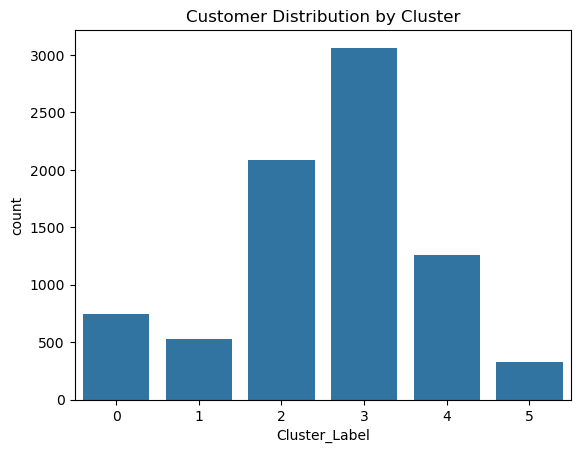

In [67]:
cluster_distribution = segmented_df["Cluster_Label"].value_counts().sort_index()
print(cluster_distribution)

# Visualize cluster distribution
sns.countplot(x="Cluster_Label", data=segmented_df)
plt.title("Customer Distribution by Cluster")
plt.show()

Insights:
Cluster Distribution: The customer distribution across clusters is imbalanced. Cluster 3 has the highest number of customers, with more than 2,000 individuals. This suggests that Cluster 3 is the most common or generalized customer group.


Cluster 0, 1, 4, and 5: These clusters contain relatively fewer customers, with Cluster 5 being the smallest. This might indicate that these clusters represent niche segments with specific behavior profiles.

Business Relevance: Understanding these distribution patterns is essential for targeting strategies. The larger cluster (Cluster 3) could be the primary focus for mass marketing campaigns, while the smaller clusters (0, 1, 4, and 5) may require more personalized approaches.

Actions:
Cluster 3: Focus on broad outreach, offers, and campaigns targeting a large group of customers.

Clusters 0, 1, 4, 5: Prioritize personalized marketing or re-engagement efforts, as these smaller groups might require tailored incentives or offers to increase their engagement and spending.

### Descriptive Statistics for Behavioral Features

In [51]:
# Group by Cluster_Label and calculate mean, median, std for behavioral columns
cluster_summary = segmented_df.groupby('Cluster_Label')[behavior_cols].agg(['mean', 'median', 'std']).reset_index()

# Display the full DataFrame nicely
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
cluster_summary

Cluster_Label      AdSpend                           EmailClicks         \
                        mean       median          std        mean median   
0             0  5103.889242  5229.798887  2910.472161    4.823529    5.0   
1             1  3828.730274  3397.140955  2624.002052    3.447419    3.0   
2             2  5093.838890  5149.299067  2837.204047    4.572252    4.0   
3             3  5178.631914  5275.004253  2783.987658    4.525147    5.0   
4             4  5071.923809  5299.371551  2897.892673    4.681021    5.0   
5             5  4120.587190  3439.768287  2698.605124    3.266667    2.0   

            WebsiteVisits                   PreviousPurchases         \
        std          mean median        std              mean median   
0  2.859659     24.383690   24.0  14.562191          4.711230    5.0   
1  2.829546     21.405354   18.0  15.378374          3.414914    3.0   
2  2.869050     25.375420   25.0  14.091379          4.548248    5.0   
3  2.778409     25.304376   25.0  13.983543          4.551274    4.0   
4  2.889065     24.736045   25.0  14.311427          4.740032    5.0   
5  2.785401     21.881818   21.0  15.362528          3.696970    3.0   

            ConversionRate                     LoyaltyPoints          \
        std           mean    median       std          mean  median   
0  2.861279       0.108279  0.111118  0.054435   2581.030749  2611.5   
1  3.021305       0.089418  0.077966  0.057824   2103.126195  1968.0   
2  2.847712       0.106172  0.105053  0.053712   2531.552088  2554.0   
3  2.815661       0.105990  0.106594  0.053724   2520.348138  2506.0   
4  2.912840       0.105696  0.104638  0.055857   2557.686603  2585.0   
5  3.075394       0.088219  0.076386  0.059094   2102.224242  1867.5   

               PagesPerVisit                     TimeOnSite            \
           std          mean    median       std       mean    median   
0  1432.119986      5.600666  5.547476  2.546665   8.052900  7.902402   
1  1463.745526      4.873681  4.484724  2.791566   5.884563  4.773280   
2  1409.915377      5.667805  5.707140  2.554658   7.742781  7.692063   
3  1403.560737      5.635073  5.628293  2.582800   8.008285  8.059086   
4  1444.127075      5.614727  5.665695  2.622089   7.997754  8.226381   
5  1527.474489      4.711097  4.084013  2.652915   6.187224  4.751000   

            SocialShares                   EmailOpens                   \
        std         mean median        std       mean median       std   
0  4.310241    50.477273   51.0  28.908076   9.596257    9.0  5.593320   
1  3.996898    51.200765   50.0  29.405017   7.801147    6.0  5.914998   
2  4.246817    49.688910   49.0  28.688951   9.641383   10.0  5.610265   
3  4.120283    50.022534   50.0  28.954500   9.639778   10.0  5.673914   
4  4.194130    48.354067   48.5  28.855321  10.070973   10.0  5.727009   
5  4.361725    50.169697   47.0  29.092270   7.054545    5.0  5.540955   

  ClickThroughRate                               CLV                        \
              mean    median       std          mean  median           std   
0         0.160125  0.163240  0.084378  12288.783422  9935.5  10724.234232   
1         0.125252  0.095009  0.084273   7205.154876  3456.0   9238.264436   
2         0.157882  0.158739  0.082709  11427.857897  8601.0  10393.833607   
3         0.158158  0.157550  0.083222  11466.701829  8429.5  10403.036198   
4         0.159188  0.160478  0.083699  12185.642743  8926.0  11025.218546   
5         0.122972  0.098416  0.083862   7870.875758  3254.5   9872.387439   

  ClickToOpenRate                          EngagementDepth             \
             mean    median            std            mean     median   
0    15909.954127  0.500000  100338.525229       45.293864  36.653066   
1    30402.284779  0.473684  123693.104232       29.490819  19.843158   
2    22228.319401  0.473684  114552.953681       43.182401  35.993412   
3    21816.602253  0.461538  112618.731609       45.471819  37.

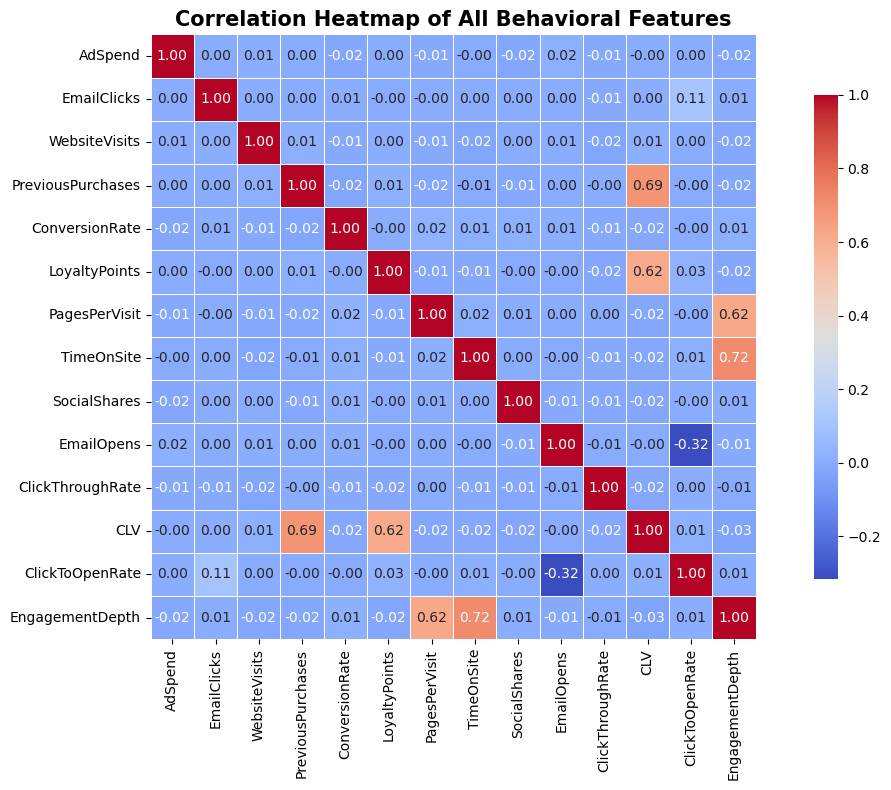

In [52]:

# ✅ Compute the correlation matrix
corr_matrix = segmented_df[behavior_cols].corr()

# ✅ Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})

plt.title('Correlation Heatmap of All Behavioral Features', fontsize=15, weight='bold')
plt.tight_layout()
plt.show()


In [53]:
anova_results_list = []

for metric in behavior_cols:
    # Group values by cluster
    groups = [segmented_df[segmented_df['Cluster_Label'] == cluster][metric]
              for cluster in segmented_df['Cluster_Label'].unique()]
    
    # Perform ANOVA
    f_stat, p_val = f_oneway(*groups)
    
    # Append results as a dict
    anova_results_list.append({
        'Metric': metric,
        'F-statistic': round(f_stat, 4),
        'p-value': round(p_val,4)
    })

# Convert results to pandas DataFrame
anova_results_df = pd.DataFrame(anova_results_list)

# Optional: Sort by p-value for clarity
anova_results_df.sort_values(by='p-value', inplace=True)

# Show the DataFrame
anova_results_df.reset_index(drop=True, inplace=True)
anova_results_df

,Metric,F-statistic,p-value
0,AdSpend,27.8560,0.0000
1,EmailClicks,30.0735,0.0000
2,WebsiteVisits,10.2342,0.0000
3,PreviousPurchases,22.9807,0.0000
4,ConversionRate,15.5091,0.0000
5,LoyaltyPoints,14.4345,0.0000
6,PagesPerVisit,15.7268,0.0000
7,TimeOnSite,33.9314,0.0000
8,EmailOpens,24.8673,0.0000
9,ClickThroughRate,25.6270,0.0000


CLV is highly correlated with PreviousPurchases and LoyaltyPoints, so CLV alone can represent financial behavior to avoid redundancy.

EngagementDepth and TimeOnSite are strongly correlated; keeping one is enough to represent digital engagement clearly.

ClickToOpenRate (CTO) and SocialShares are dropped due to low significance and weak correlation, adding little value to the analysis.

In [54]:
#update behavior_cols
behavior_cols = [
    'PreviousPurchases',
    'LoyaltyPoints',
    'ConversionRate',
    'CLV',
    'PagesPerVisit',
    'TimeOnSite',
    'EmailClicks',
    'EmailOpens',
    'ClickThroughRate',
    'EngagementDepth'
]


### Normalized Heatmap of Mean Behavioral Metrics by Cluster

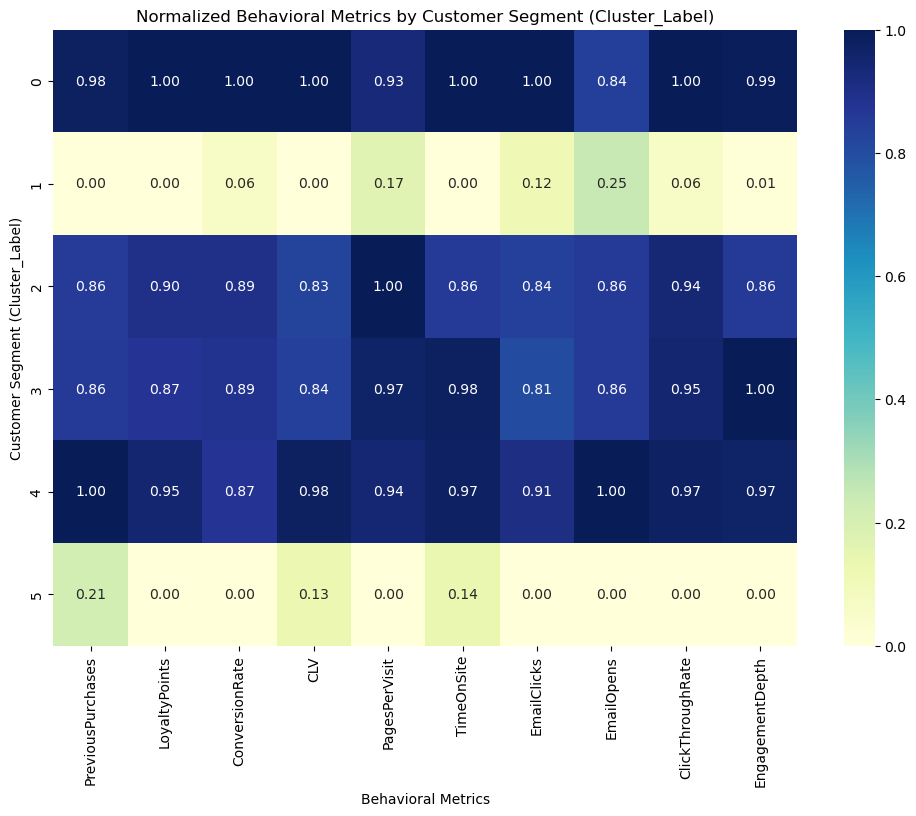

In [55]:
# Group by Cluster_Label and compute mean of behavioral features
cluster_behavior_means = segmented_df.groupby('Cluster_Label')[behavior_cols].mean()

# Normalize (Min-Max Scaling) for each feature (column-wise)
normalized_means = (cluster_behavior_means - cluster_behavior_means.min()) / (cluster_behavior_means.max() - cluster_behavior_means.min())

# Plot normalized heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(normalized_means, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Normalized Behavioral Metrics by Customer Segment (Cluster_Label)")
plt.xlabel("Behavioral Metrics")
plt.ylabel("Customer Segment (Cluster_Label)")
plt.show()


###  Cluster Highlights:
- **Cluster 0**: Strong across all behaviors — high loyalty, CLV, and digital engagement. Best for **retention and upsell**.
- **Cluster 1**: Very low in all metrics — likely **inactive or churned** customers.
- **Cluster 2**: Solid digital engagement (**PagesPerVisit high**) with good transaction potential.
- **Cluster 3**: Balanced, strong in **EngagementDepth** — good for **cross-sell or content campaigns**.
- **Cluster 4**: High digital activity (**EmailClicks max**) and solid CLV — target for **personalized offers**.
- **Cluster 5**: Low across most metrics — **new or churn-risk** group.

###  Action Summary:
- **Focus**: Cluster 0, 4 — maximize value.
- **Nurture**: Cluster 2, 3 — grow engagement.
- **Reactivate / Mitigate churn**: Cluster 1, 5.

In [56]:
#new list for behaviral analysis
product_usage_cols = ['PreviousPurchases', 'LoyaltyPoints']
transaction_history_cols = ['ConversionRate', 'CLV']
digital_engagement_cols = ['PagesPerVisit', 'TimeOnSite', 'EmailClicks', 'EmailOpens', 'ClickThroughRate', 'EngagementDepth']

### product usage

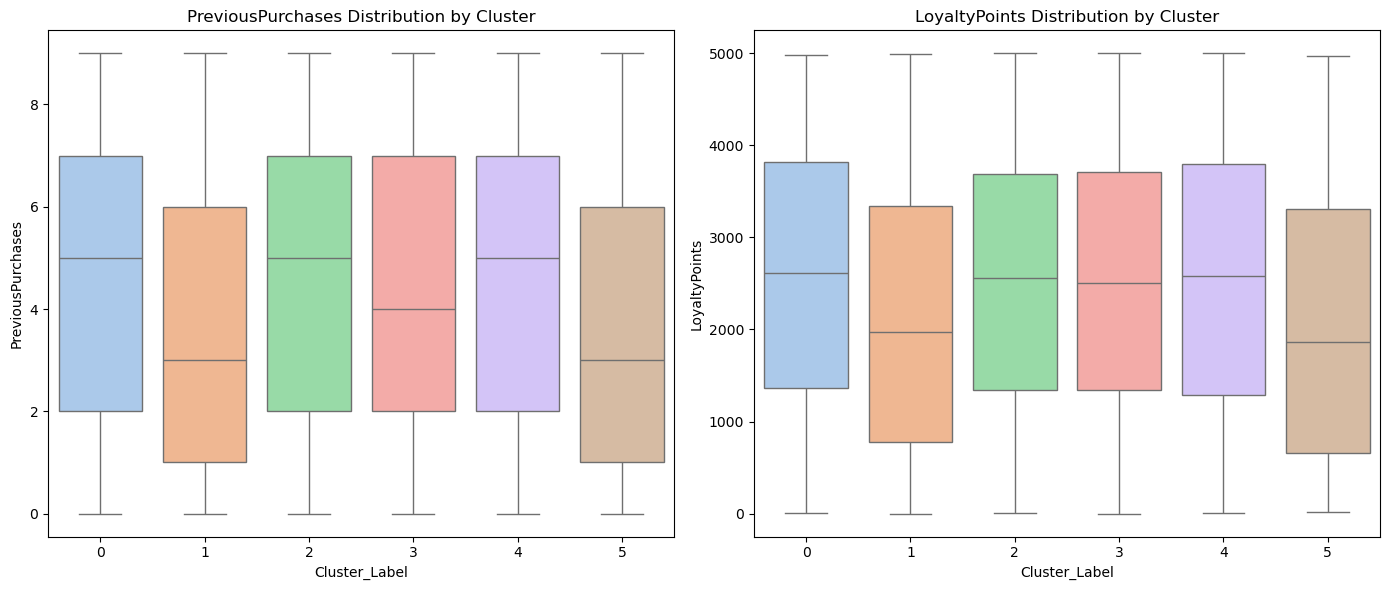

In [57]:

# Boxplots for Product Usage by Cluster
plt.figure(figsize=(14, 6))
for i, feature in enumerate(['PreviousPurchases', 'LoyaltyPoints']):
    plt.subplot(1, 2, i + 1)
    sns.boxplot(data=segmented_df, x='Cluster_Label', y=feature, hue='Cluster_Label', palette='pastel', legend=False)
    plt.title(f'{feature} Distribution by Cluster')
plt.tight_layout()
plt.show()




High-Value Clusters (e.g., Cluster 5): Likely the most profitable group. Strategies: Upselling, loyalty rewards.

Low-Value Clusters (e.g., Cluster 0): May require incentives (discounts, personalized offers) to boost activity.

Mid-Tier Clusters (1–4): Opportunity to nurture these customers into higher tiers via targeted campaigns.


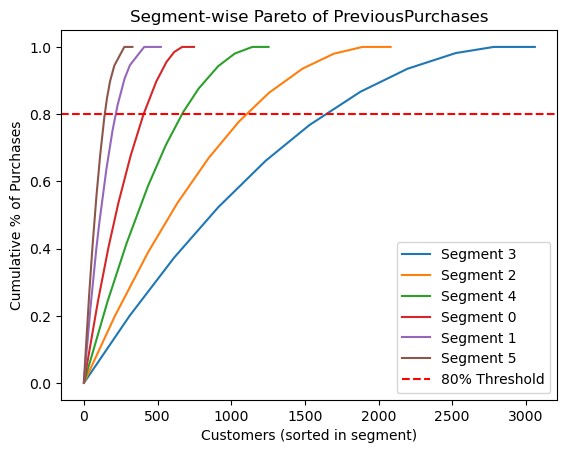

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Pareto within cluster
for cluster in segmented_df['Cluster_Label'].unique():
    cluster_data = segmented_df[segmented_df['Cluster_Label'] == cluster]
    sorted_purchases = cluster_data['PreviousPurchases'].sort_values(ascending=False).reset_index(drop=True)
    cumulative = sorted_purchases.cumsum() / sorted_purchases.sum()

    plt.plot(cumulative, label=f'Segment {cluster}')

plt.axhline(0.8, color='red', linestyle='--', label='80% Threshold')
plt.legend()
plt.title('Segment-wise Pareto of PreviousPurchases')
plt.xlabel('Customers (sorted in segment)')
plt.ylabel('Cumulative % of Purchases')
plt.show()


Segments 5 and 1 are whale-driven — focus premium loyalty programs here.

Segments 2 and 3 have broad contributors — mass engagement works best.

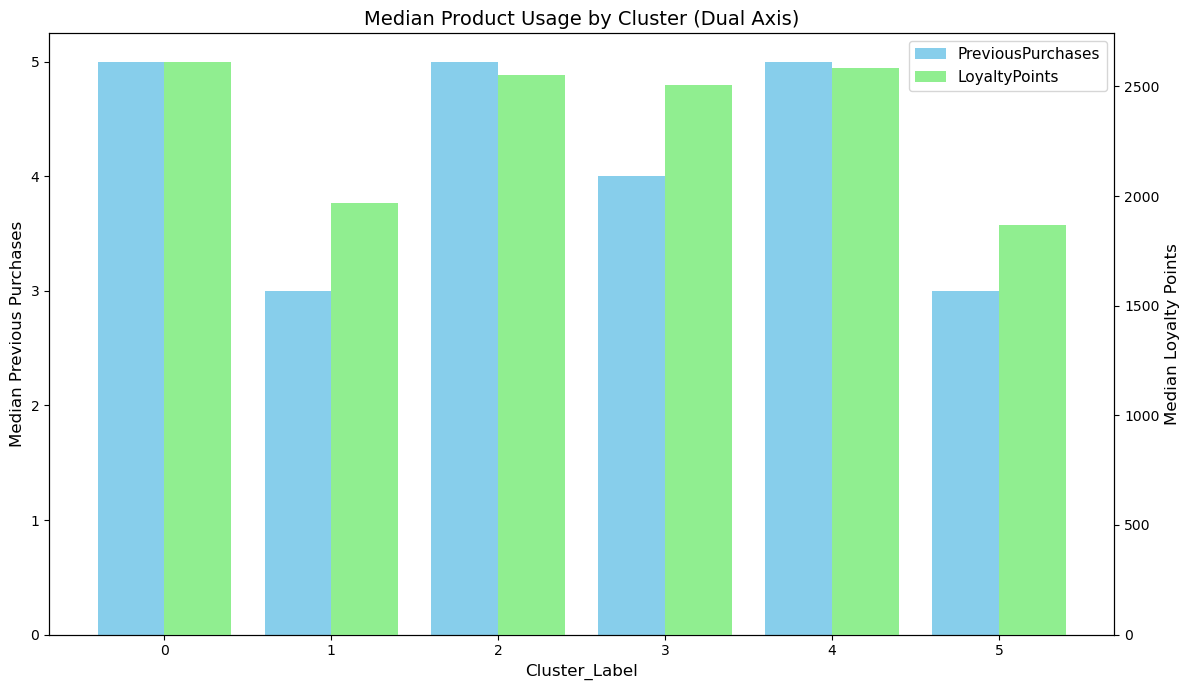

In [68]:
# Dual Axis Product Usage (Median)

# Group data by Cluster_Label and calculate the median for each cluster
usage = segmented_df.groupby('Cluster_Label')[['PreviousPurchases', 'LoyaltyPoints']].median()

# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot PreviousPurchases on ax1
width = 0.4
bar1 = ax1.bar(usage.index - width/2, usage['PreviousPurchases'], width=width, color='skyblue', label='PreviousPurchases')
ax1.set_ylabel('Median Previous Purchases', fontsize=12)
ax1.set_xlabel('Cluster_Label', fontsize=12)
ax1.tick_params(axis='y', labelsize=10)

# Create twin axis for LoyaltyPoints
ax2 = ax1.twinx()
bar2 = ax2.bar(usage.index + width/2, usage['LoyaltyPoints'], width=width, color='lightgreen', label='LoyaltyPoints')
ax2.set_ylabel('Median Loyalty Points', fontsize=12)
ax2.tick_params(axis='y', labelsize=10)

# Title and layout adjustments
plt.title('Median Product Usage by Cluster (Dual Axis)', fontsize=14)
fig.tight_layout()

# Custom legend
bars = [bar1[0], bar2[0]]
labels = ['PreviousPurchases', 'LoyaltyPoints']
plt.legend(bars, labels, loc='upper right', fontsize=11)

plt.show()


Clusters 0, 2, 3, 4 → Consistent good purchasing AND loyalty

Cluster 1 & 5 → Lower in both loyalty and purchases

### Transaction History

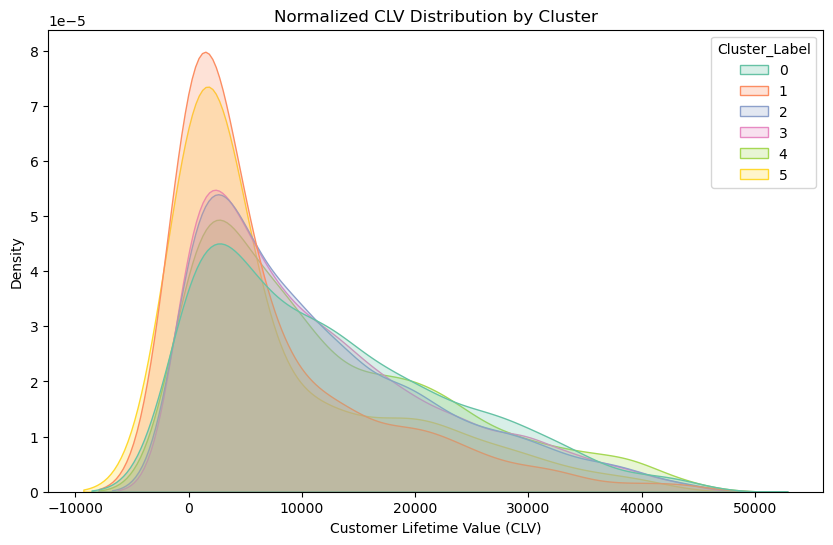

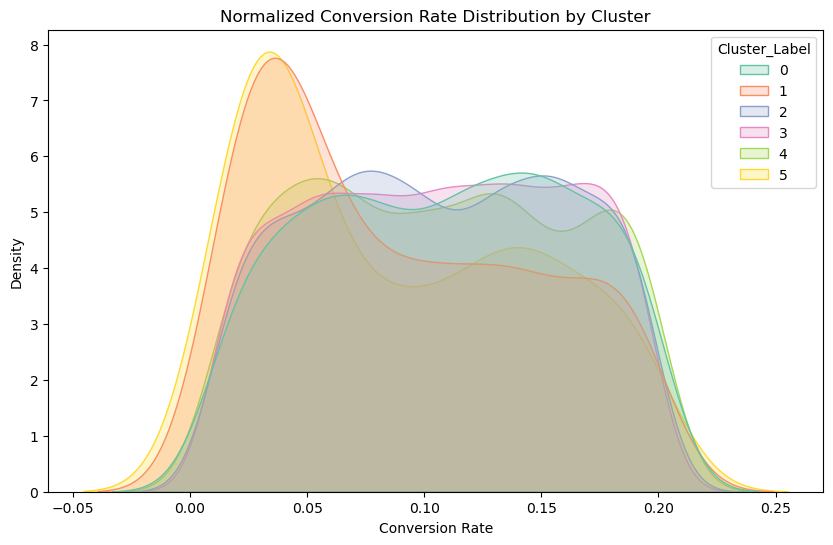

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot for CLV with normalization
plt.figure(figsize=(10, 6))
sns.kdeplot(data=segmented_df, x='CLV', hue='Cluster_Label', fill=True, palette='Set2', common_norm=False)
plt.title('Normalized CLV Distribution by Cluster')
plt.xlabel('Customer Lifetime Value (CLV)')
plt.ylabel('Density')
plt.show()

# Plot for ConversionRate with normalization
plt.figure(figsize=(10, 6))
sns.kdeplot(data=segmented_df, x='ConversionRate', hue='Cluster_Label', fill=True, palette='Set2', common_norm=False)
plt.title('Normalized Conversion Rate Distribution by Cluster')
plt.xlabel('Conversion Rate')
plt.ylabel('Density')
plt.show()


Cluster 3: Prioritize — high-value, high conversion. Use loyalty rewards, personalized offers.

Cluster 2: Good conversion potential — push conversion-driven campaigns.

Clusters 0, 4: Test re-engagement or consider exit strategies.

Clusters 1 & 5: Low ROI — shift focus unless for churn prevention

In [62]:
from scipy.stats import pearsonr, spearmanr

# Pearson Correlation
pearson_corr, pearson_p = pearsonr(segmented_df['ConversionRate'], segmented_df['CLV'])
print(f"Pearson Correlation: {pearson_corr:.3f}, p-value: {pearson_p:.4f}")

# Spearman Correlation (better if data is non-linear / skewed)
spearman_corr, spearman_p = spearmanr(segmented_df['ConversionRate'], segmented_df['CLV'])
print(f"Spearman Correlation: {spearman_corr:.3f}, p-value: {spearman_p:.4f}")


Pearson Correlation: -0.015, p-value: 0.1762
Spearman Correlation: -0.022, p-value: 0.0502


CLV and Conversion Rate are almost uncorrelated.

A high conversion rate does not guarantee a high customer lifetime value (CLV).

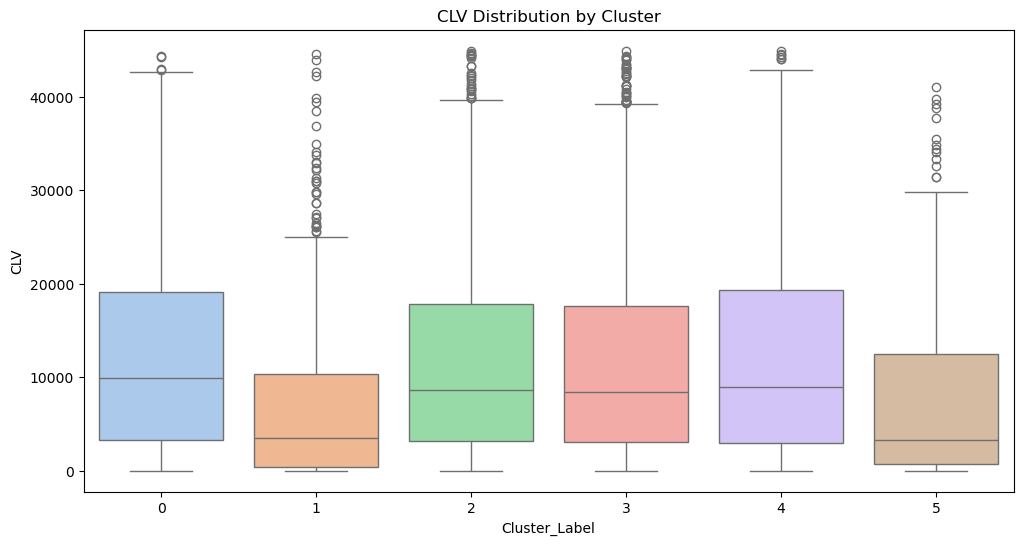

In [63]:
# Boxplot for CLV - Outlier detection
# revenue potential analysis
plt.figure(figsize=(12, 6))
sns.boxplot(data=segmented_df, x='Cluster_Label', y='CLV', hue='Cluster_Label', palette='pastel', legend=False)
plt.title('CLV Distribution by Cluster')
plt.show()

Cluster 3: Prioritize — high-value, high conversion. Use loyalty rewards, personalized offers.

Cluster 2: Good conversion potential — push conversion-driven campaigns.

Clusters 0, 4: Test re-engagement or consider exit strategies.

Clusters 1 & 5: Low ROI — shift focus unless for churn prevention

### Digital Engagement

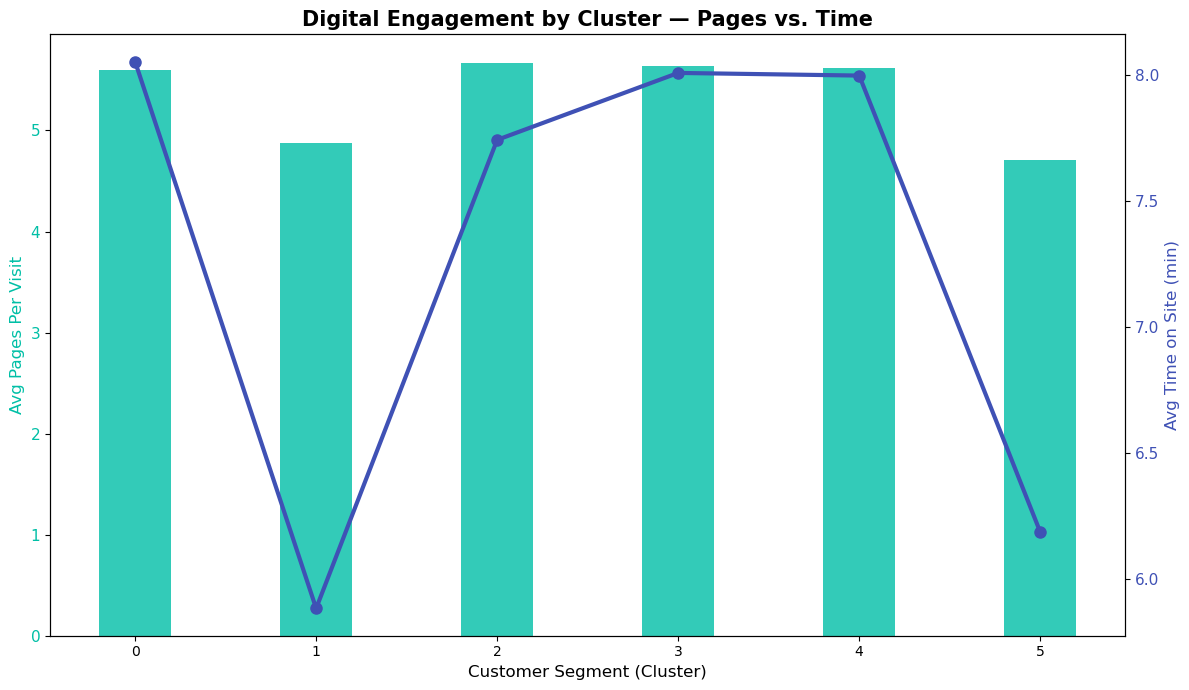

In [64]:
# ✅ 1. Dual-Axis Plot: TimeOnSite vs PagesPerVisit

# Prepare the average engagement dataframe first
engagement_avg = segmented_df.groupby('Cluster_Label')[['PagesPerVisit', 'TimeOnSite']].mean().reset_index()

# ✅ 1. Dual-Axis Plot: TimeOnSite vs PagesPerVisit
fig, ax1 = plt.subplots(figsize=(12, 7))

# Softer teal for PagesPerVisit bar
bar_color = '#00BFA6'  # Nice teal green
ax1.bar(engagement_avg['Cluster_Label'], 
        engagement_avg['PagesPerVisit'], 
        color=bar_color, 
        width=0.4, 
        alpha=0.8)
ax1.set_xlabel('Customer Segment (Cluster)', fontsize=12)
ax1.set_ylabel('Avg Pages Per Visit', color=bar_color, fontsize=12)
ax1.tick_params(axis='y', labelcolor=bar_color, labelsize=11)

# Deep purple-blue for TimeOnSite line
line_color = '#3F51B5'  # Indigo / Blue-violet
ax2 = ax1.twinx()
ax2.plot(engagement_avg['Cluster_Label'], 
         engagement_avg['TimeOnSite'], 
         color=line_color, 
         marker='o', 
         linewidth=3, 
         markersize=8, 
         label='Avg Time On Site')
ax2.set_ylabel('Avg Time on Site (min)', color=line_color, fontsize=12)
ax2.tick_params(axis='y', labelcolor=line_color, labelsize=11)

plt.title('Digital Engagement by Cluster — Pages vs. Time', fontsize=15, weight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()




Insight — Digital Engagement by Cluster (Pages vs. Time)

Cluster 0, 2, 3, 4 show strong engagement:

High Pages Per Visit (~5.5+)

High Time on Site (~8 minutes)

Indicates these segments browse more content and stay longer — potential for content-driven strategies.

Cluster 1 and 5 are weak in digital engagement:

Lower Pages Per Visit (~4.8 - 5)

Shortest Time on Site (~6 minutes)

Likely less interested or drop-off early — needs re-engagement.

 Overall takeaway:

Segment 0/2/3/4 → Prime candidates for deeper digital campaigns (articles, product recommendations).

Segment 1 & 5 → Reactivation or simplified journeys needed (quick CTAs, fewer clicks).

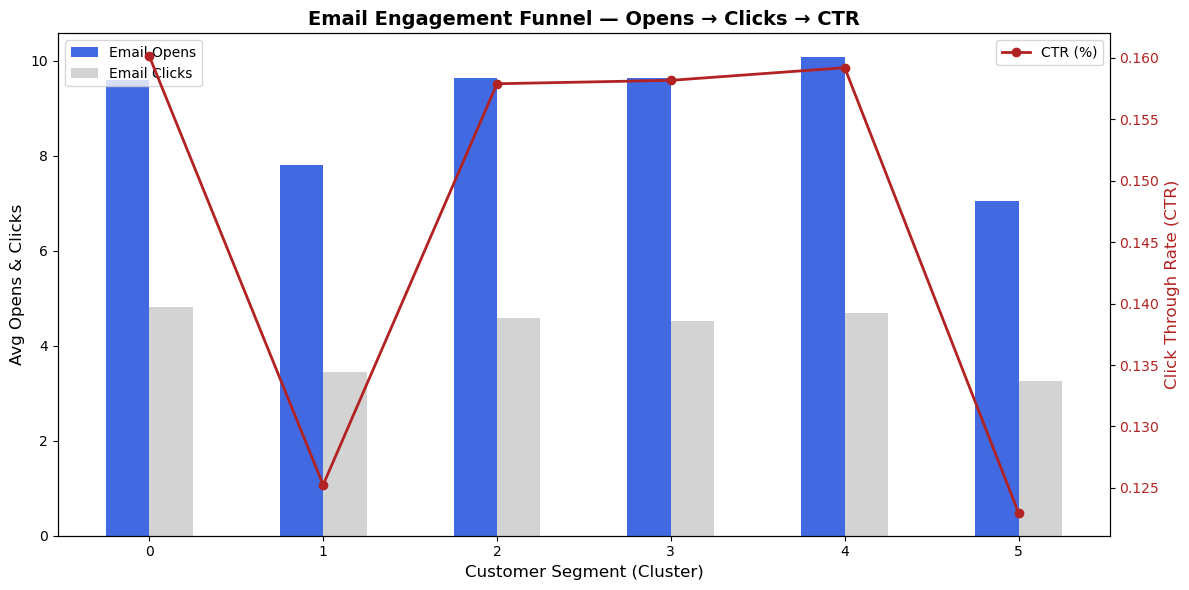

In [65]:
# Prepare the average email engagement dataframe
email_avg = segmented_df.groupby('Cluster_Label')[['EmailOpens', 'EmailClicks', 'ClickThroughRate']].mean().reset_index()

import numpy as np
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(12, 6))

bar_width = 0.25
x = np.arange(len(email_avg['Cluster_Label']))

# Bar for Email Opens
ax1.bar(x, email_avg['EmailOpens'], width=bar_width, label='Email Opens', color='royalblue')

# Bar for Email Clicks
ax1.bar(x + bar_width, email_avg['EmailClicks'], width=bar_width, label='Email Clicks', color='lightgray')
ax1.set_ylabel('Avg Opens & Clicks', fontsize=12)
ax1.set_xlabel('Customer Segment (Cluster)', fontsize=12)

# Add CTR as a line plot on twin axis
ax2 = ax1.twinx()
ax2.plot(x + bar_width / 2, email_avg['ClickThroughRate'], color='firebrick', marker='o', linewidth=2, label='CTR (%)')
ax2.set_ylabel('Click Through Rate (CTR)', color='firebrick', fontsize=12)
ax2.tick_params(axis='y', labelcolor='firebrick')

# X-axis labels
ax1.set_xticks(x + bar_width / 2)
ax1.set_xticklabels(email_avg['Cluster_Label'])

# Titles and legends
plt.title('Email Engagement Funnel — Opens → Clicks → CTR', fontsize=14, weight='bold')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()



Clear leakage from Opens → Clicks → CTR across lower-performing clusters (1, 5).

Clusters 0 & 4 respond best to email → focus future personalized campaigns here.

Clusters 1 & 5 need re-engagement strategies or content adjustment.

In [66]:

# ✅ 6. Correlation test: EmailOpens impact on ClickThroughRate
from scipy.stats import pearsonr
pearson_corr, pval = pearsonr(segmented_df['EmailOpens'], segmented_df['ClickThroughRate'])
print(f"\nPearson Correlation between EmailOpens and CTR: {pearson_corr:.4f}, p-value = {pval:.4f}")


Pearson Correlation between EmailOpens and CTR: -0.0061, p-value = 0.5869


Email Opens alone are not enough → focus on improving Clicks & CTR for actual engagement.

## targeted marketing recommendation for each segment

Segment 0 — High Engagement & Transaction Value
Profile: High CLV, strong product usage (PreviousPurchases & LoyaltyPoints), good email engagement.

Tactics:

Loyalty Campaigns: Exclusive VIP rewards, early product access.

Cross-sell/Upsell: Personalized offers based on past purchase patterns.

Referral Incentives: Leverage their high loyalty for word-of-mouth campaigns.

High-Value Email Content: Product guides, premium content — they open & click.

Segment 1 — Low Engagement, Low Transaction
Profile: Low across almost all metrics; low digital engagement, low CLV.

Tactics:

Reactivation Campaign: Win-back emails with heavy discounts.

Simplified CTA: One clear offer per email (avoid complex journeys).

A/B Test Ad Spend: Check if any re-engagement works before investing more.

Segment 2 — Strong Digital, Average Transaction
Profile: High TimeOnSite, EmailEngagement good, moderate CLV.

Tactics:

Retargeting Ads: Convert browsers into buyers (since they spend time on site).

Conversion-Focused Emails: Push urgency — limited-time offers.

Personalized Web Experience: Recommend products while they’re active.

Segment 3 — High Email Openers, Weak Conversion
Profile: Opens emails a lot, but CTR and conversion weak.

Tactics:

Content/CTA Optimization: A/B test email layouts, buttons, product highlights.

Incentivized Clicks: Hidden deals inside emails (click to reveal).

Engagement Survey: Ask why they’re not converting → gather insights.

Segment 4 — Steady Performer
Profile: Balanced in engagement and transaction metrics.

Tactics:

Maintain Engagement: Send regular personalized recommendations.

Test New Formats: Video email content or interactive elements.

Introduce Loyalty Tiers: Gamify progress to push them toward top segments.

Segment 5 — Transaction Drop-Off, Low Digital
Profile: Low CLV, weak in all digital metrics.

Tactics:

Exit Survey: Understand churn reasons.

SMS Push (Non-Digital): Might respond better to offline or direct prompts.

Minimal Budget Allocation: Monitor, but don’t heavily invest.